# Анализ бизнес-показателей развлекательного приложения

Работа выполнена для развлекательного мобильного приложения. Несмотря на значительные вложения в рекламу, компания последние несколько месяцев терпит убытки. Необходимо разораться в причинах и помочь компании выйти в плюс. Для анализа предоставлен лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):
- User Id — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Session start — дата и время начала сессии
- Session End — дата и время окончания сессии
- Channel — идентификатор рекламного источника, из которого пришел пользователь
- Region - страна пользователя

Таблица orders_log_short (информация о заказах):

- User Id — уникальный id пользователя, который сделал заказ
- Event Dt — дата и время покупки
- Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

- Channel — идентификатор рекламного источника
- Dt — дата
- Costs — затраты на этот рекламный источник в этот день

# Загрузка данных и подготовка их к анализу.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
try:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
except:
    print('Ошибка загрузки')

In [4]:
# напишем функцию для удобства проверки таблиц
def head_info(df):
    print ('Число дубликатов', df.duplicated().sum())
    print (df.info())
    display (df.head())

Приведем таблицы в подходящий для анализа вид.

In [5]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
head_info(visits)

Число дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


То же самое сделаем с таблицами orders и costs.

In [6]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
head_info(orders)

Число дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [7]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
head_info(costs)

Число дубликатов 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


,dt,channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


# Написание функции для расчета и анализа LTV, ROI, удержания и конверсии

#### Расчет удержания

In [8]:
def get_profiles(visits, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [9]:
profiles = get_profiles(visits, orders, costs)

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Расчет конверсии

In [11]:
def get_conversion(
    profiles,
    orders, 
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):


    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    def group_by_dimensions(df, dims, horizon_days):

        
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        
        result = result.fillna(0).cumsum(axis = 1)

        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

       
        result = result.div(result['cohort_size'], axis=0)

        
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        result['cohort_size'] = cohort_sizes
        return result

    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    return result_raw, result_grouped, result_in_time 

#### Расчет LVT и ROI

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

# Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [13]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [14]:
profiles.agg({'first_ts' : ['min', 'max']})

,first_ts
min,2019-05-01 00:00:41
max,2019-10-27 23:59:04


Минимальная дата привлечения пользователей - 01-05-2019, максимальная - 27.10.2019.

Все новые пользователи не войдут в анализ, поскольку мы смотрим результаты 1 ноября 2019 года, а не все новопривлеченные пользователи к этому моменту успели "прожить" все лайфтаймы (14 дней). Последняя когорта в нашем исследовании будет та, которая сформирована 18 октября.

In [15]:
country = (
    profiles
    .pivot_table(index='region', values ='user_id', aggfunc='count')
    .rename(columns={'user_id' : 'users'})
)
country['payers'] = profiles.query('payer == True').groupby('region')['user_id'].count()
country['percent_of_payers'] = (country['payers'] / country['users'])*100
country

,users,payers,percent_of_payers
region,,,
France,17450,663,3.80
Germany,14981,616,4.11
UK,17575,700,3.98
United States,100002,6902,6.90


Посетители приходят из стран: Франция, Германия, Соединенное Королевство, США. Больше всего платящих пользователей приходит из США.

In [16]:
devices = (
    profiles
    .pivot_table(index='device', values ='user_id', aggfunc='count')
    .rename(columns={'user_id' : 'users'})
)
devices['payers'] = profiles.query('payer == True').groupby('device')['user_id'].count()
devices['percent_of_payers'] = (devices['payers'] / devices['users'])*100
devices

,users,payers,percent_of_payers
device,,,
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05
iPhone,54479,3382,6.21


Пользователи заходят с устройств: Android, Mac, PC, iPhone. Больше всего платящих пользователей заходит с устройств iPhone.

In [17]:
channels = (
    profiles
    .pivot_table(index='channel', values ='user_id', aggfunc='count')
    .rename(columns={'user_id' : 'users'})
)
channels['payers'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channels['percent_of_payers'] = (channels['payers'] / channels['users'])*100
channels

,users,payers,percent_of_payers
channel,,,
AdNonSense,3880,440,11.34
FaceBoom,29144,3557,12.20
LeapBob,8553,262,3.06
MediaTornado,4364,156,3.57
OppleCreativeMedia,8605,233,2.71
RocketSuperAds,4448,352,7.91
TipTop,19561,1878,9.60
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83


Пользователи приходят по следующим каналам: FaceBoom, AdNonSense, YRabbit, MediaTornado, RocketSuperAds, LeapBob, TipTop, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds, organic. Больше всего платящих пользователей приходит через канал FaceBoom.

# Оценка затрат на маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [42]:
# сколько денег всего потратили
costs['costs'].sum().round(2)

105497.3

In [19]:
# сколько денег потратили на каждый источник
costs.groupby('channel')['costs'].sum().sort_values(ascending = False)


channel
TipTop               54751.30
FaceBoom             32445.60
WahooNetBanner        5151.00
AdNonSense            3911.25
OppleCreativeMedia    2151.25
RocketSuperAds        1833.00
LeapBob               1797.60
lambdaMediaAds        1557.60
MediaTornado           954.48
YRabbit                944.22
Name: costs, dtype: float64

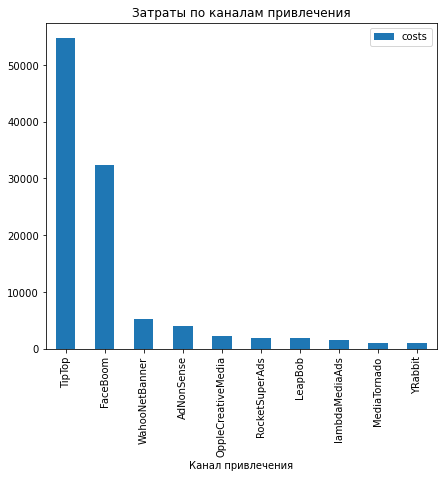

In [20]:
(
    costs
    .pivot_table(index='channel', values ='costs', aggfunc='sum')
    .sort_values(by='costs', ascending=False)
    .plot(figsize=(7,6), kind='bar')
)
plt.xlabel('Канал привлечения')
plt.title('Затраты по каналам привлечения');
# согласно комментарию добавила сортировку по величине и подписи и заголовок

In [21]:
# сколько потратили по времени
costs.groupby('dt')['costs'].sum()

dt
2019-05-01   304.82
2019-05-02   230.84
2019-05-03   263.07
2019-05-04   337.00
2019-05-05   319.90
              ...  
2019-10-23   593.00
2019-10-24   737.59
2019-10-25   862.60
2019-10-26   952.37
2019-10-27   967.17
Name: costs, Length: 180, dtype: float64

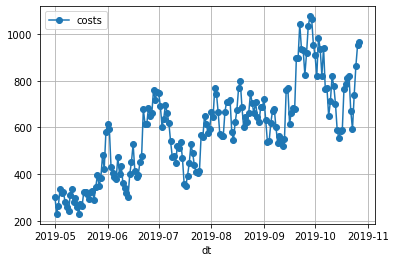

In [22]:
(
    costs
    .pivot_table(index='dt', values='costs', aggfunc='sum')
    .plot(style='o-', grid=True)
);

In [23]:
#cколько в среднем стоило привлечение одного покупателя из каждого источника
profiles = profiles.query('channel != "organic"') 
profiles.groupby('channel')['acquisition_cost'].mean()

channel
AdNonSense           1.01
FaceBoom             1.11
LeapBob              0.21
MediaTornado         0.22
OppleCreativeMedia   0.25
RocketSuperAds       0.41
TipTop               2.80
WahooNetBanner       0.60
YRabbit              0.22
lambdaMediaAds       0.72
Name: acquisition_cost, dtype: float64

In [50]:
# средний CAC
round(profiles['acquisition_cost'].mean(), 2)

1.13

# Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишем проблемы, которые были обнаружены. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучить конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела. При решении этого шага будем считать, что смотрим данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [25]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

### Проанализируем общую окупаемость рекламы

In [26]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [27]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

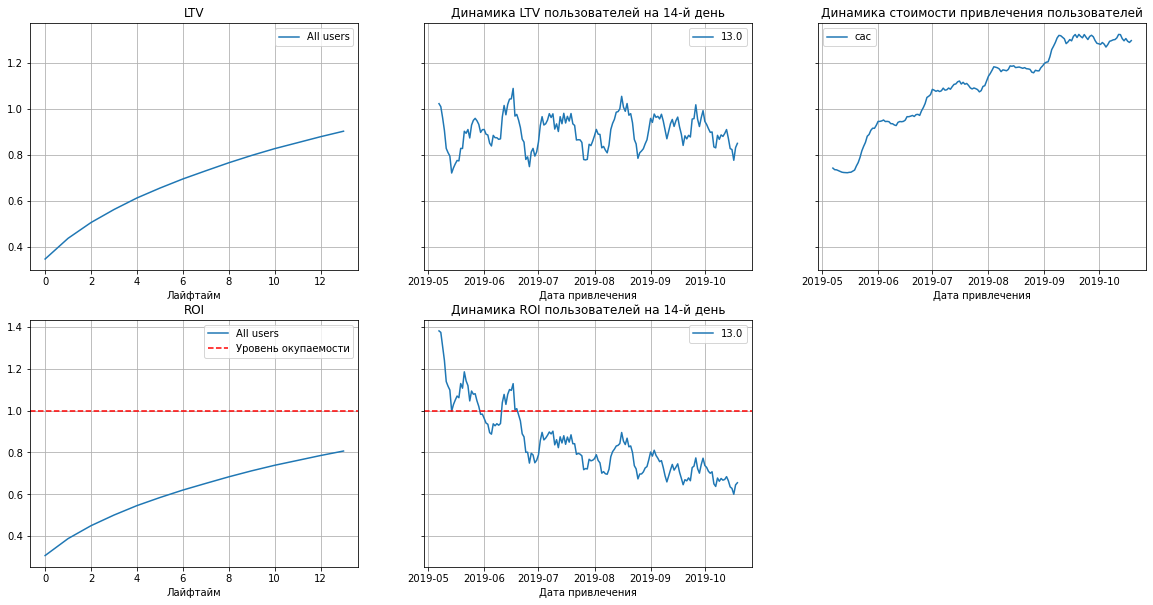

In [28]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI в конце исследуемого периода достигает только 80%.
- CAC нестабилен. Значит, увеличение рекламного бюджета себя не оправдывает.
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

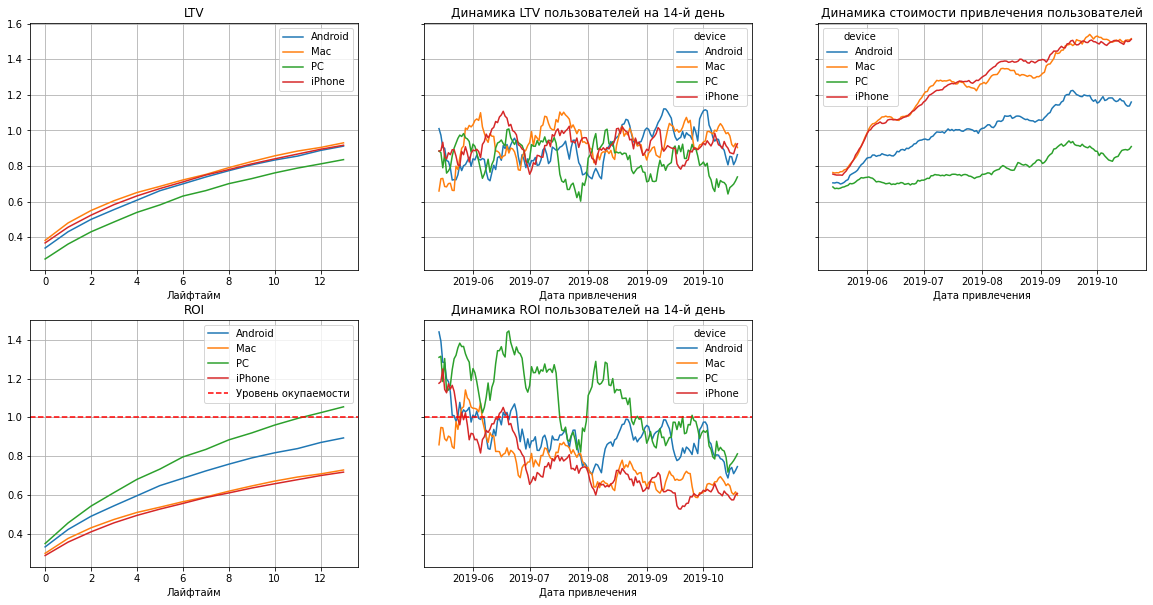

In [29]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### Проанализируем окупаемость рекламы с разбивкой по странам

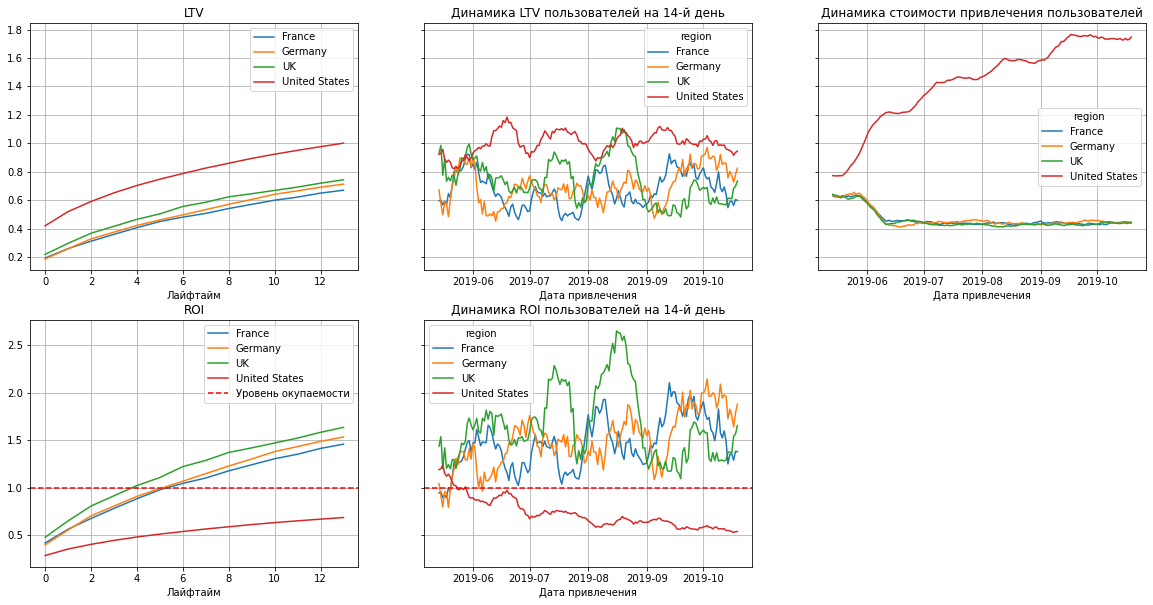

In [30]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

### Проанализировать окупаемость рекламы с разбивкой по рекламным каналам

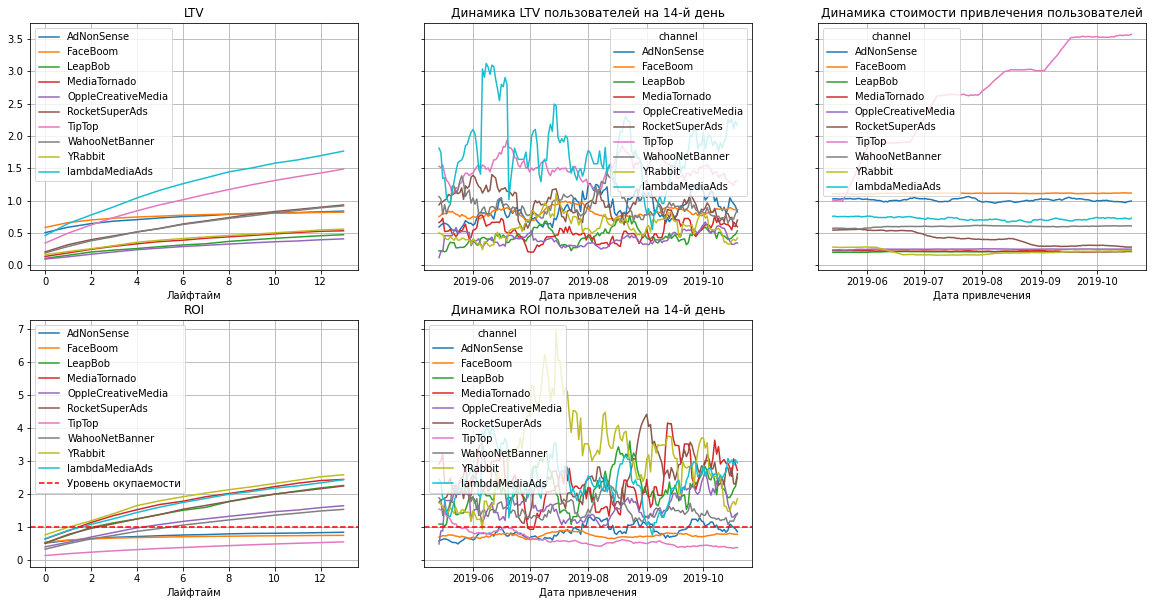

In [31]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


По устройствам ROI ниже уровня окупаемости у MAC, iPhone и Android.
По странам ROI ниже уровня окупаемости у США.
По рекламным каналам ROI ниже уровня окупаемости у TipTop, FaceBoom и AdNonSense.

Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

In [32]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [33]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

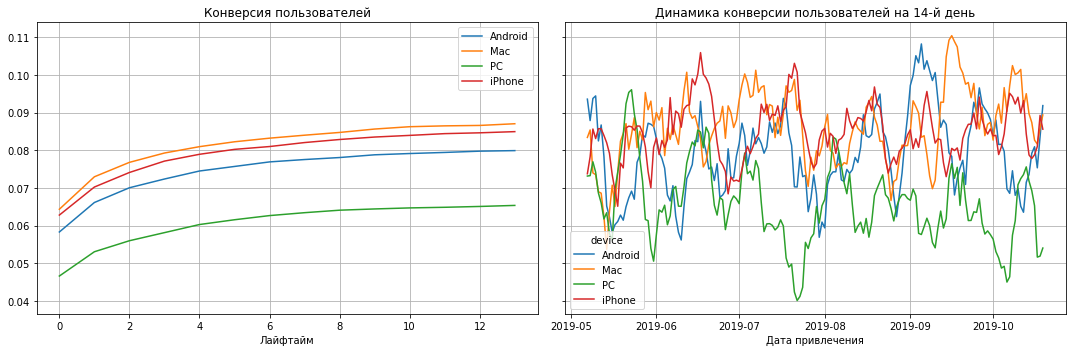

In [34]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

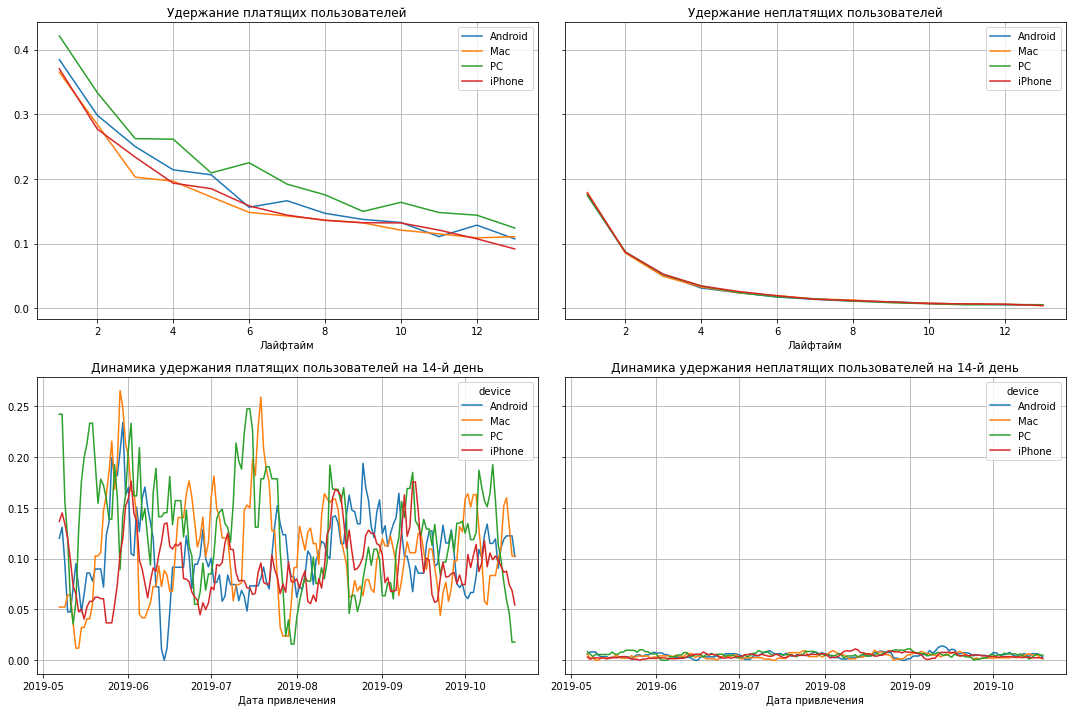

In [35]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

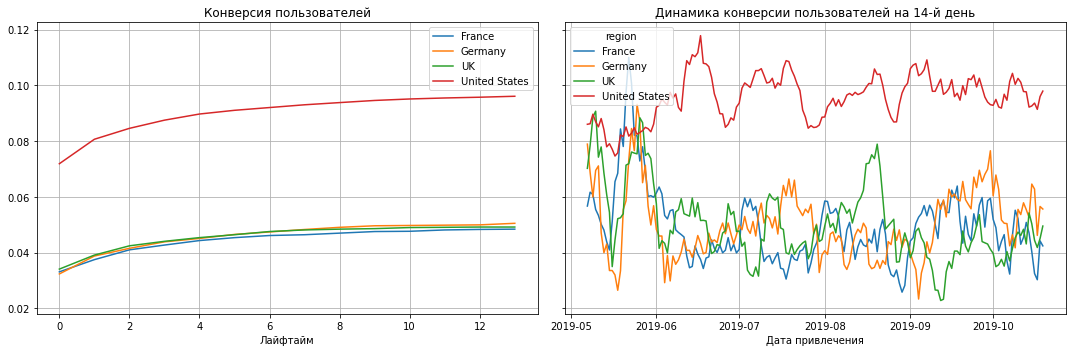

In [36]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

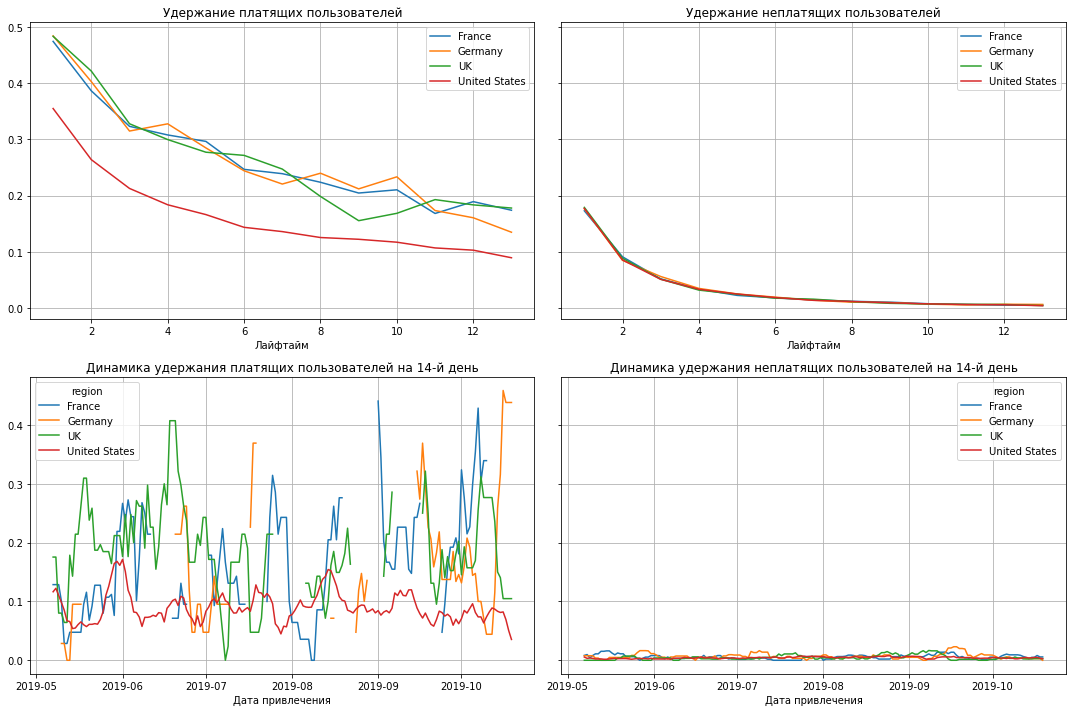

In [37]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

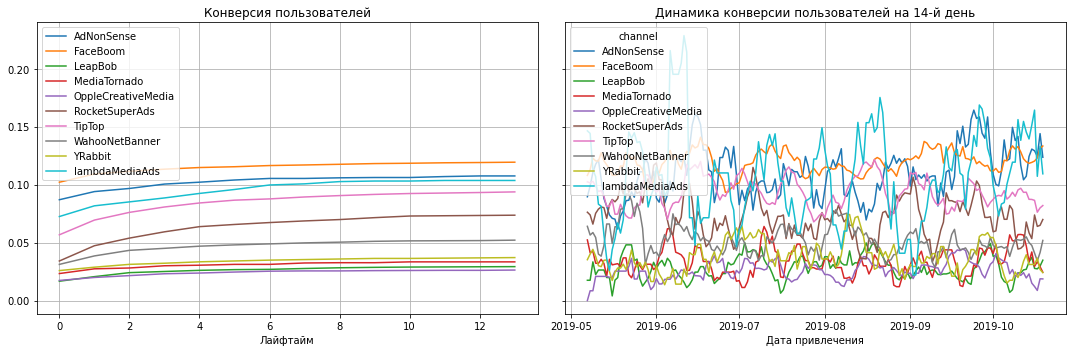

In [38]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

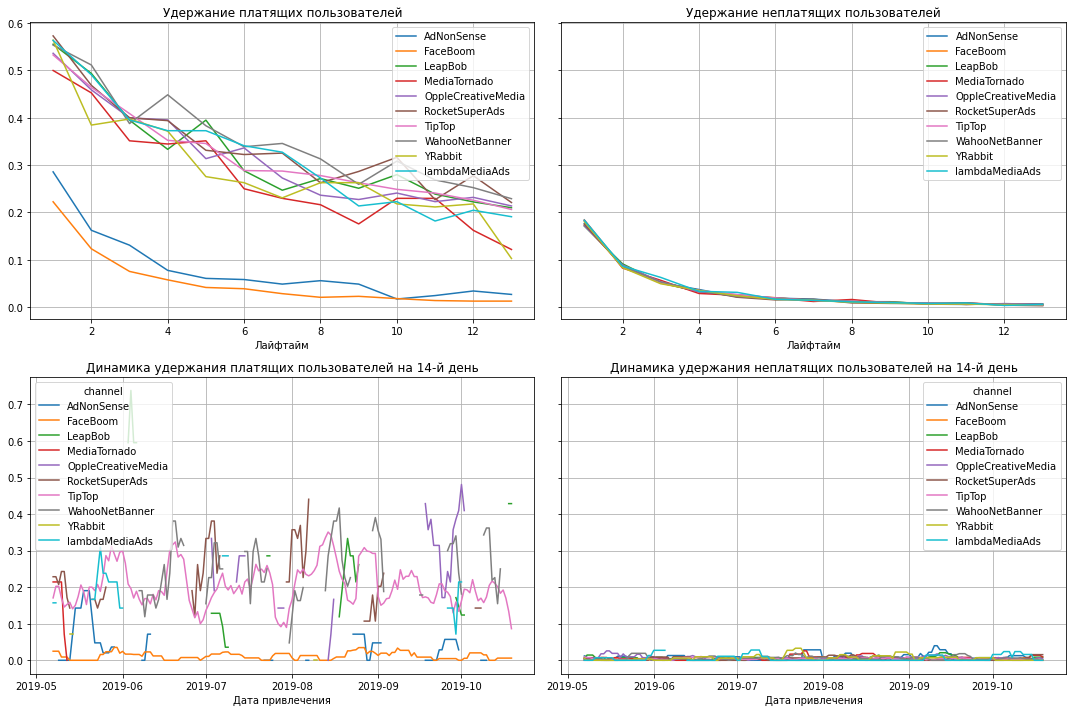

In [39]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

# Шаг 6. Основные выводы
- Выделим причины неэффективности привлечения пользователей;
- Сформируем рекомендации для отдела маркетинга для повышения эффективности.

Можно сделать вывод, что реклама не окупается, затраты на рекламу большие, но платежей мало: при высокой конверсии низкое удержание.
Складывается впечатление, что есть какая-то проблема с устройствами. Посмотрим зависимость от региона и канала привлечения.

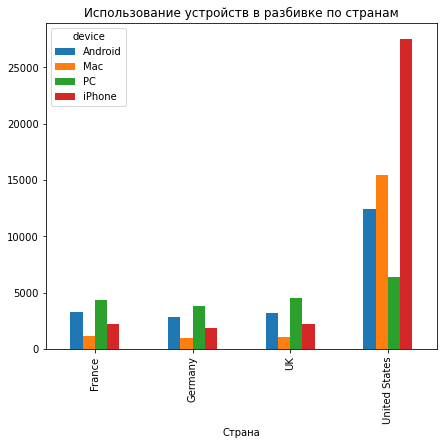

In [40]:
(
    profiles
    .pivot_table(index='region', columns='device', values ='user_id', aggfunc='count')
    .plot(figsize=(7,6), kind='bar')
)
plt.xlabel('Страна')
plt.title('Использование устройств в разбивке по странам');

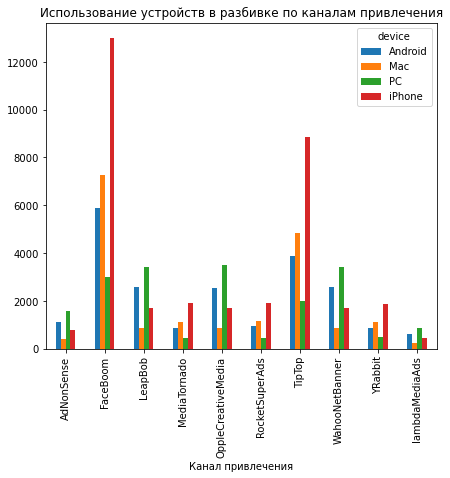

In [41]:
(
    profiles
    .pivot_table(index='channel', columns='device', values ='user_id', aggfunc='count')
    .plot(figsize=(7,6), kind='bar')
)
plt.xlabel('Канал привлечения')
plt.title('Использование устройств в разбивке по каналам привлечения');

Действительно, с мобильных устройств приходит больше всего пользователей в США, а также из каналов TipTop и Faceboom.Однако удержание по этим устройствам низкое. Необходимо в срочном порядке проверить, какие проблемы возникают у пользователей этих устройств, например, по журналу событий. 